In [57]:
# Create DATASET
import numpy as np
import pandas as pd

np.random.seed(0)

n = 1000

# Generate a synthetic (artificial) dataset that follows a Normal Distribution (also known as a Gaussian or "Bell Curve" distribution)
# It may generate negative numbers, so wrap it
amount = np.maximum(0, np.random.normal(2000, 800, n).round(1))
frequency = np.maximum(0, np.random.normal(3, 1.5, n).round(1))

fraud = ((amount > 3000) & (frequency > 3)).astype(int)

df = pd.DataFrame({
    "amount": amount,
    "frequency": frequency,
    "fraud": fraud
})

df.head()


,amount,frequency,fraud
0,3411.2,3.8,1
1,2320.1,4.3,0
2,2783.0,2.4,0
3,3792.7,3.2,1
4,3494.0,3.3,1


In [58]:
# Train Logistic Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = df[["amount", "frequency"]]
y = df["fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Scale it to make money on same scale as freq
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", LogisticRegression())
])

pipe.fit(X_train, y_train)



,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scale', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wor

In [ ]:
# Probabilities vs Predictions

# The prov var contains a list of pairs. Each pair represents the probability for Class 0(Legit) and Class 1(Fraud).
probs = pipe.predict_proba(X_test)
# The preds var shows prediction. By default, scikitLearn uses a 0.5(50%) threshold. Fraud is >0.5
preds = pipe.predict(X_test)

print(probs[:5])

# Create a small table to see the link
results = pd.DataFrame(probs, columns=["Prob_Legit (0)", "Prob_Fraud (1)"])
results['Final_Prediction'] = preds
print(results)

# Show ONLY the rows where the model predicted Fraud
print(results[results['Final_Prediction'] == 1])

print("\nHighest Fraud Probability found:", results['Prob_Fraud (1)'].max())


[[9.99992193e-01 7.80720403e-06]
 [9.99998360e-01 1.63969919e-06]
 [9.99999132e-01 8.68344254e-07]
 [9.99969454e-01 3.05464838e-05]
 [9.99296567e-01 7.03432888e-04]]
     Prob_Legit (0)  Prob_Fraud (1)  Final_Prediction
0          0.999992    7.807204e-06                 0
1          0.999998    1.639699e-06                 0
2          0.999999    8.683443e-07                 0
3          0.999969    3.054648e-05                 0
4          0.999297    7.034329e-04                 0
..              ...             ...               ...
295        1.000000    7.534698e-08                 0
296        0.999689    3.105632e-04                 0
297        0.999993    6.952218e-06                 0
298        0.999991    9.382363e-06                 0
299        0.999301    6.987602e-04                 0

[300 rows x 3 columns]
     Prob_Legit (0)  Prob_Fraud (1)  Final_Prediction
5          0.088074        0.911926                 1
23         0.326112        0.673888                 1


In [60]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
print(cm)


[[280   2]
 [  7  11]]


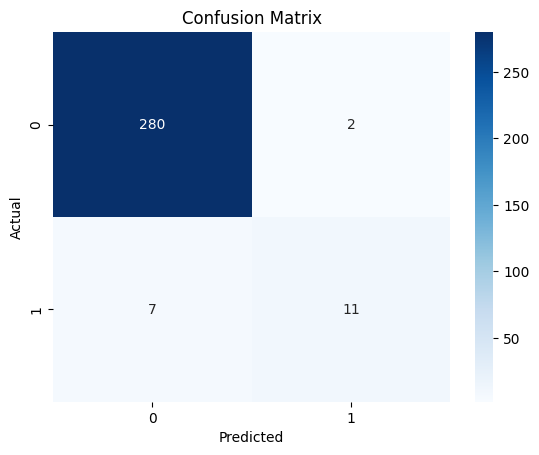

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


f:\Python code\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


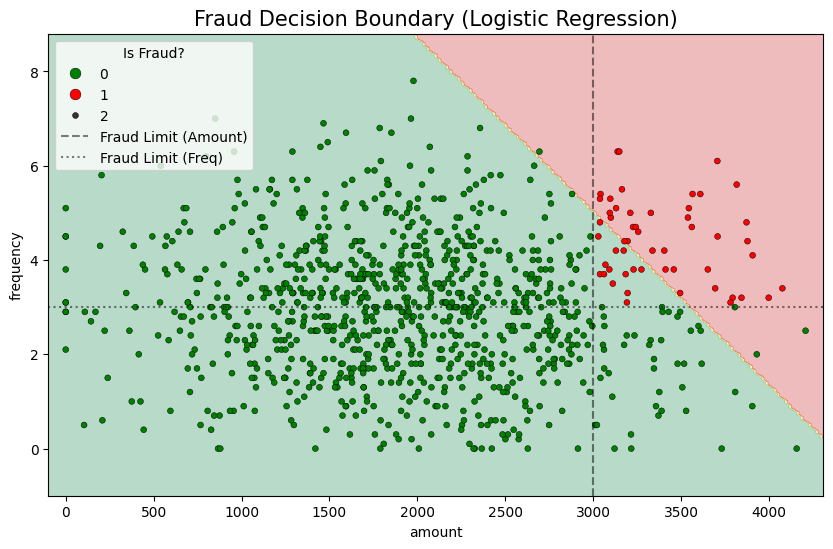

In [ ]:
# Plot the classification graph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the plot boundaries based on your data
x_min, x_max = X['amount'].min() - 100, X['amount'].max() + 100
y_min, y_max = X['frequency'].min() - 1, X['frequency'].max() + 1

# 2. Create a mesh grid of points
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# 3. Predict the class for every point in the grid
# Use pipe.predict to get the background zones
Z = pipe.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 4. Plotting
plt.figure(figsize=(10, 6))

# Draw the colored zones (Green for Legit, Red for Fraud)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn_r')

# Plot your actual data points on top
sns.scatterplot(data=df, x='amount', y='frequency', hue='fraud', 
                palette={0: 'green', 1: 'red'},size=2, edgecolor='k', s=60)

# Add reference lines for your original logic (Amount > 3000 & Freq > 3)
plt.axvline(3000, color='black', linestyle='--', alpha=0.5, label='Fraud Limit (Amount)')
plt.axhline(3, color='black', linestyle=':', alpha=0.5, label='Fraud Limit (Freq)')

plt.title('Fraud Decision Boundary (Logistic Regression)', fontsize=15)
plt.legend(title='Is Fraud?', loc='upper left')
plt.show()


In [67]:
# Metrics

from sklearn.metrics import precision_score, recall_score, f1_score

# High precision → fewer false alarms: Of all flagged frauds, how many were truly fraud?
print("Precision:", precision_score(y_test, preds))

# High recall → fewer misses: Of all real frauds, how many did we catch?
print("Recall:", recall_score(y_test, preds))

# Balance metric: to measure the perfomance, and for tuning threshold
print("F1:", f1_score(y_test, preds))


Precision: 0.8461538461538461
Recall: 0.6111111111111112
F1: 0.7096774193548387


In [ ]:
# ROC and AUC: How well can this model separate classes?

from sklearn.metrics import roc_curve, roc_auc_score

y_probs = pipe.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

print("AUC:", auc)


AUC: 0.9891646966115052


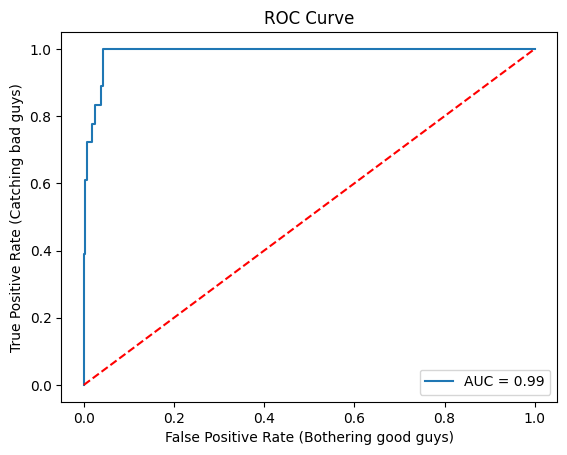

In [68]:
# Plot the ROC curve (with AUC line)
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--') # The "Random Guess" line
plt.xlabel('False Positive Rate (Bothering good guys)')
plt.ylabel('True Positive Rate (Catching bad guys)')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [66]:
# Thresshold Tuning

custom_preds = (y_probs > 0.3).astype(int)

print(confusion_matrix(y_test, custom_preds))
print("Precision:", precision_score(y_test, custom_preds))
print("Recall:", recall_score(y_test, custom_preds))
print("F1:", f1_score(y_test, custom_preds))



[[275   7]
 [  3  15]]
Precision: 0.6818181818181818
Recall: 0.8333333333333334
F1: 0.75


default
0    486
1     14
Name: count, dtype: int64


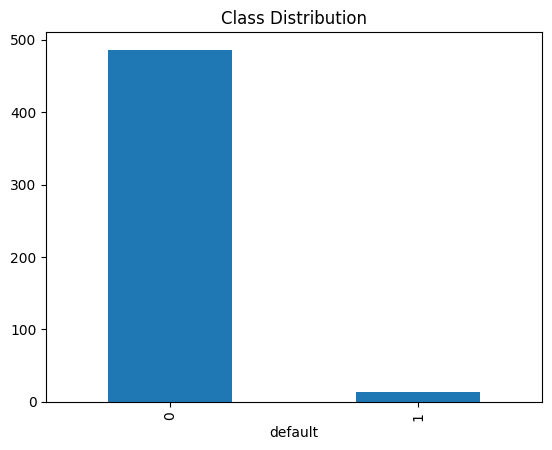

In [2]:
#### ADVANCED TOPICS ####

# 1. Handeling Imbalanced Data:
# Handling imbalanced data refers to the techniques used in machine learning to address datasets where the classes (categories) are not represented equally. 
# For example, in fraud detection, 99% of transactions might be legitimate, while only 1% are fraudulent. If you train a model on this data normally, it might achieve 99% accuracy just by guessing "not fraud" every time, making it useless for actually catching fraud. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

n = 500
income = np.random.normal(50000, 15000, n)
debt = np.random.normal(20000, 8000, n)

# Very simple data with no noise( easy to find its math )
default = ((debt > 30000) & (income < 40000)).astype(int)
 
df = pd.DataFrame({
    "income": income,
    "debt": debt,
    "default": default
})

print(df["default"].value_counts())

# Visual Imbalance

df["default"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.show()


In [3]:
# TECHNIQUES: Resampling
# 1. Oversampling: Adding more copies of the minority class to balance it.
# 2. Undersampling: Removing some examples from the majority class to balance it.

from sklearn.utils import resample

minority = df[df.default == 1]
majority = df[df.default == 0]

minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)

df_balanced = pd.concat([majority, minority_upsampled])


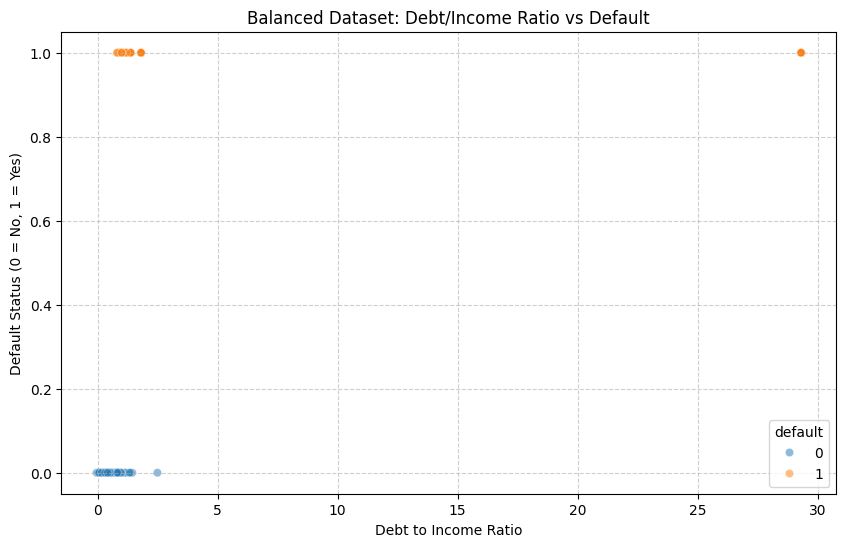

In [4]:
# 2. Feature Engineering for Classification: Better features often outperform better models.
# EX: usage_per_day, inactive_flag, debt_income_ratio

import matplotlib.pyplot as plt
import seaborn as sns

# 1. First, create the ratio column in the balanced dataframe
df_balanced["debt_income_ratio"] = df_balanced["debt"] / df_balanced["income"]

# 2. Plotting
plt.figure(figsize=(10, 6))

# Use 'hue' to color the points by Default status
sns.scatterplot(data=df_balanced, 
                x="debt_income_ratio", 
                y="default", 
                hue="default", 
                alpha=0.5)

plt.title("Balanced Dataset: Debt/Income Ratio vs Default")
plt.xlabel("Debt to Income Ratio")
plt.ylabel("Default Status (0 = No, 1 = Yes)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()




--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        87
           1       0.25      0.15      0.19        13

    accuracy                           0.83       100
   macro avg       0.57      0.54      0.55       100
weighted avg       0.80      0.83      0.81       100


--- Feature Importances ---
[0.31832231 0.68167769]


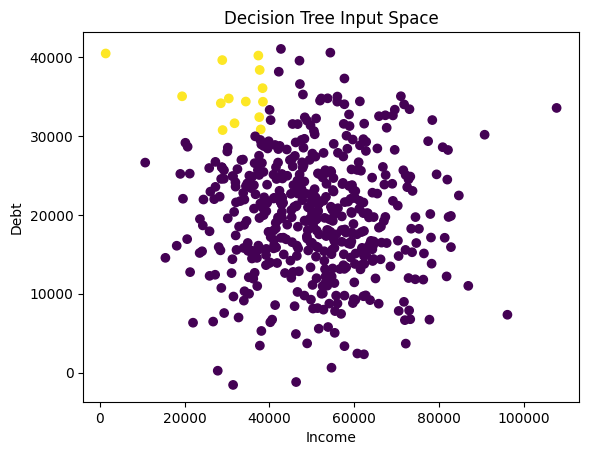

In [5]:
# 2. Decision Trees (Interpretable Models)
# The Decision Tree's job is to use your input features (Income and Debt) to draw a series of invisible, straight lines (boundaries) on this graph to perfectly separate the purple dots from the yellow dots.
# (METRICS BEFORE BALANCING DATA)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 1. Flip 15% of the labels randomly to create noise
noise_mask = np.random.random(n) < 0.15
df["default_noisy"] = np.where(noise_mask, 1 - df["default"], df["default"])

# 2. Re-train using the noisy labels
X = df[["income", "debt"]]
y = df["default_noisy"]

# 3. Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train on ONLY the training set
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

# 5. Predict on the "Unseen" testing set
y_pred = model.predict(X_test)

# 6. Check the report again
print("--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))

# Feature importance
print("\n--- Feature Importances ---")
print(model.feature_importances_)

# Visualizing decision boundary
plt.scatter(df["income"], df["debt"], c=df["default"])
plt.xlabel("Income")
plt.ylabel("Debt")
plt.title("Decision Tree Input Space")
plt.show()


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        99
           1       0.83      0.91      0.87        96

    accuracy                           0.86       195
   macro avg       0.86      0.86      0.86       195
weighted avg       0.86      0.86      0.86       195


--- Feature Importances ---
[0.16049274 0.83950726]


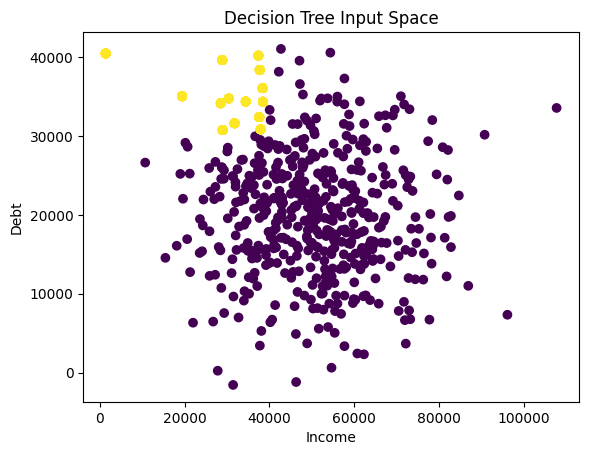

In [6]:
# 2. Decision Trees (Interpretable Models)
# The Decision Tree's job is to use your input features (Income and Debt) to draw a series of invisible, straight lines (boundaries) on this graph to perfectly separate the purple dots from the yellow dots.
# (METRICS AFTER BALANCING DATA)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 1. Flip 15% of the labels randomly to create noise
noise_mask = np.random.random(len(df_balanced)) < 0.15
df_balanced["default_noisy"] = np.where(noise_mask, 1 - df_balanced["default"], df_balanced["default"])

# 2. Re-train using the noisy labels
X = df_balanced[["income", "debt"]]
y = df_balanced["default_noisy"]

# 3. Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train on ONLY the training set
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

# 5. Predict on the "Unseen" testing set
y_pred = model.predict(X_test)

# 5. Check the report again
print("--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))

# Feature importance
print("\n--- Feature Importances ---")
print(model.feature_importances_)

# Visualizing decision boundary
plt.scatter(df_balanced["income"], df_balanced["debt"], c=df_balanced["default"])
plt.xlabel("Income")
plt.ylabel("Debt")
plt.title("Decision Tree Input Space")
plt.show()


# Recall for Class 1 (0.83): Your model is now catching 83% of defaults. Compared to your previous score of 0.15 (15%), this is a huge win. You are actually identifying the high-risk cases now.
# Precision for Class 1 (0.90): This is excellent. When the model flags someone as a "Default," it is correct 90% of the time. It isn't just crying wolf; its predictions are highly reliable.
# Macro Avg (0.85): Notice how your accuracy (0.85) and your Macro Average (0.85) are now the same. This proves the model is equally strong at predicting both "Defaults" and "Non-Defaults."
# Balanced Support (83 vs 112): Since the test set is balanced, the model can no longer "cheat" by only predicting the majority class.

In [7]:
# 3. Random Forest( with many trees average prediction: robust)
# A Random Forest takes the idea of a single Decision Tree and scales it up. Instead of relying on just one set of rules, it creates hundreds of individual decision trees and averages their decisions.
# (WITH ONLY 2 FEATURES, USE SCATTER PLOT DECESION BOUNDARY)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming 'df_balanced' and 'default_noisy' are already set up from previous steps

# 1. Create the new feature in the balanced dataframe
df_balanced["debt_income_ratio"] = df_balanced["debt"] / df_balanced["income"]

# 2. Define features (X) to include the new ratio
X = df_balanced[["income", "debt"]]
y = df_balanced["default_noisy"]

# 3. Split data (using the same split for consistency)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize the Random Forest model
#    We use n_estimators (number of trees) and class_weight='balanced'
rf_model = RandomForestClassifier(n_estimators=100, 
                                  class_weight='balanced', 
                                  random_state=42)

# 5. Train the model
rf_model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = rf_model.predict(X_test)
print("--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))

# 7. Check Feature Importance (which feature mattered most?)
print("\n--- Feature Importances ---")
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.74      0.81        99
           1       0.77      0.92      0.84        96

    accuracy                           0.83       195
   macro avg       0.84      0.83      0.82       195
weighted avg       0.84      0.83      0.82       195


--- Feature Importances ---
debt      0.567777
income    0.432223
dtype: float64


f:\Python code\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


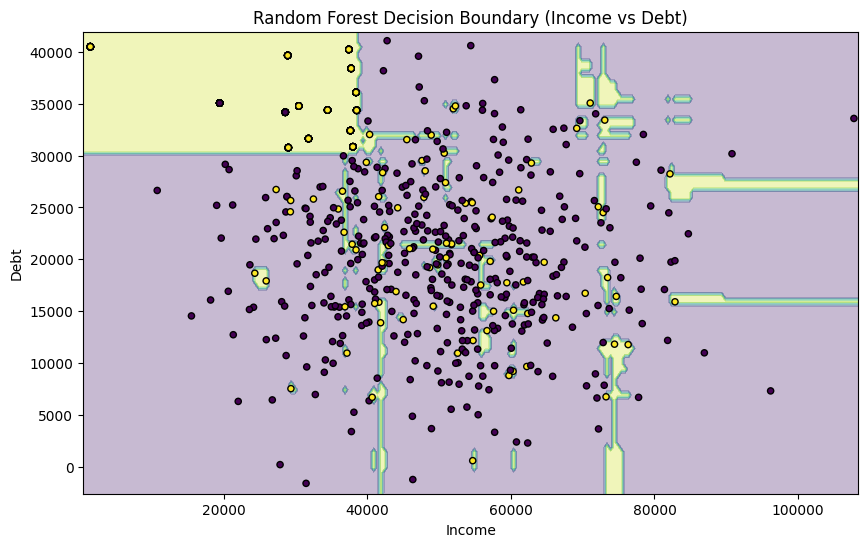

In [8]:
# (WITH ONLY 2 FEATURES, USE SCATTER PLOT DECESION BOUNDARY)

import matplotlib.pyplot as plt
import numpy as np

# Ensure we are using the 'rf_model' trained with 'income' and 'debt' features only for this plot
X_plot = df_balanced[["income", "debt"]]
y_plot = df_balanced["default_noisy"]

# Define the mesh grid boundaries
x_min, x_max = X_plot["income"].min() - 1000, X_plot["income"].max() + 1000
y_min, y_max = X_plot["debt"].min() - 1000, X_plot["debt"].max() + 1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, 500), # Step size for income
                     np.arange(y_min, y_max, 500)) # Step size for debt

# Predict the class for every point in the mesh
Z = rf_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the colored background and data points
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis') # Background color regions
plt.scatter(X_plot["income"], X_plot["debt"], c=y_plot, cmap='viridis', edgecolors='k', s=20) # Actual data points

plt.xlabel("Income")
plt.ylabel("Debt")
plt.title("Random Forest Decision Boundary (Income vs Debt)")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        99
           1       0.82      0.91      0.86        96

    accuracy                           0.86       195
   macro avg       0.86      0.86      0.86       195
weighted avg       0.86      0.86      0.86       195


--- Feature Importances ---
debt                 0.386546
debt_income_ratio    0.323061
income               0.290393
dtype: float64


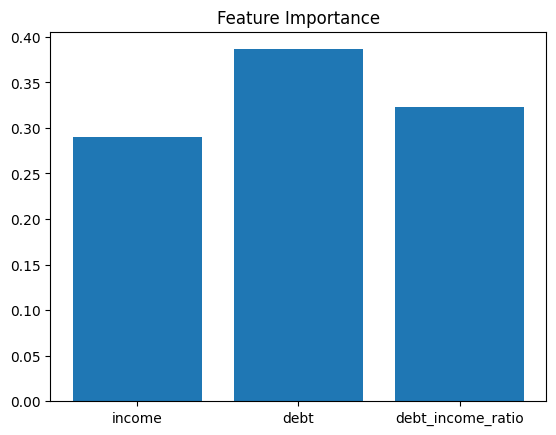

In [9]:
# 3. Random Forest( with many trees average prediction: robust)
# A Random Forest takes the idea of a single Decision Tree and scales it up. Instead of relying on just one set of rules, it creates hundreds of individual decision trees and averages their decisions.
# (WITH MORE THAN 2 FEATURES, USE SIMPLE BAR GRAPH TO SHOW EACH FEATURES IMPORTANCE)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming 'df_balanced' and 'default_noisy' are already set up from previous steps

# 1. Create the new feature in the balanced dataframe
df_balanced["debt_income_ratio"] = df_balanced["debt"] / df_balanced["income"]

# 2. Define features (X) to include the new ratio
X = df_balanced[["income", "debt", "debt_income_ratio"]]
y = df_balanced["default_noisy"]

# 3. Split data (using the same split for consistency)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize the Random Forest model
#    We use n_estimators (number of trees) and class_weight='balanced'
rf_model = RandomForestClassifier(n_estimators=100, 
                                  class_weight='balanced', 
                                  random_state=42)

# 5. Train the model
rf_model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = rf_model.predict(X_test)
print("--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))

# 7. Check Feature Importance (which feature mattered most?)
print("\n--- Feature Importances ---")
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# By adding the debt_income_ratio (a derived feature), you provided the model with a more potent, pre-calculated metric that summarized the relationship between debt and income effectively. 
# The Random Forest smartly adjusted its internal logic to heavily utilize this new, highly informative feature.

# Feature importance graph
plt.bar(["income","debt","debt_income_ratio"], rf_model.feature_importances_)
plt.title("Feature Importance")
plt.show()

--- Gradient Boosting Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        99
           1       0.81      0.91      0.85        96

    accuracy                           0.85       195
   macro avg       0.85      0.85      0.85       195
weighted avg       0.85      0.85      0.85       195


--- Feature Importances ---
debt                 0.720466
income               0.217289
debt_income_ratio    0.062246
dtype: float64


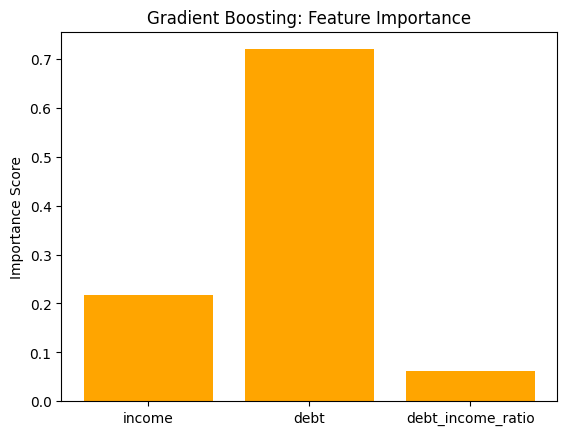

In [10]:
# 4. Gradient Boosting (Powerful models)
# Each new model learns: “Where previous model made mistakes”

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# 1. & 2. Feature Engineering (Same as your RF code)
df_balanced["debt_income_ratio"] = df_balanced["debt"] / df_balanced["income"]
X = df_balanced[["income", "debt", "debt_income_ratio"]]
y = df_balanced["default_noisy"]

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize the Gradient Boosting model
# Gradient Boosting doesn't have a 'class_weight' parameter like RF. 
# We use learning_rate to control how fast the model adapts to errors.
gb_model = GradientBoostingClassifier(n_estimators=100, 
                                      learning_rate=0.1, 
                                      max_depth=3, 
                                      random_state=42)

# 5. Train the model
gb_model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = gb_model.predict(X_test)
print("--- Gradient Boosting Classification Report ---")
print(classification_report(y_test, y_pred))

# 7. Check Feature Importance
print("\n--- Feature Importances ---")
feature_importances = pd.Series(gb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# Feature importance graph
plt.bar(X.columns, gb_model.feature_importances_, color='orange')
plt.title("Gradient Boosting: Feature Importance")
plt.ylabel("Importance Score")
plt.show()



In [ ]:
# 5. Stratified Cross Validation
# It is the "gold standard" for evaluating how well a machine learning model will perform on data it hasn't seen before.
# Instead of testing your model just once, this process tests it five different times on different slices of your data to ensure the results aren't just a "lucky guess."
# Normal CV may split uneven classes.
# Stratified CV keeps class ratio consistent.

from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5)

scores = cross_val_score(rf_model, X, y, cv=skf)
print(scores.mean())



0.8056621728786677


In [ ]:
# The following code compares five common classifiers: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, and SVM. 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd

# 1. Define the models you want to compare
models = [
    ("LogReg", LogisticRegression(max_iter=1000)),
    ("DecTree", DecisionTreeClassifier(random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("GradBoost", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("SVM", SVC())
]

# 2. Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# 3. Loop through each model and calculate cross-validation scores
print(f"{'Model':<15} | {'Mean Accuracy':<15} | {'Std Dev'}")
print("-" * 45)

for name, model in models:
    # Use cross_val_score to automate training and testing 5 times
    # Scoring: accuracy, precision, recall, f1, roc_auc
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    results.append((name, mean_score))
    
    print(f"{name:<15} | {mean_score:.4f}          | {std_score:.4f}")

# 4. Find the winner
winner = max(results, key=lambda x: x[1])
print(f"\n🏆 The best performing model is: {winner[0]} with {winner[1]:.4f} accuracy")


Model           | Mean Accuracy   | Std Dev
---------------------------------------------
LogReg          | 0.8056          | 0.0306
DecTree         | 0.7706          | 0.0055
RandomForest    | 0.8241          | 0.0090
GradBoost       | 0.8189          | 0.0116
SVM             | 0.8210          | 0.0223

🏆 The best performing model is: RandomForest with 0.8241 accuracy


In [ ]:
# Metrics of any single model
from sklearn.model_selection import cross_validate

# Define the metrics you care about
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Run the validation
cv_results = cross_validate(rf_model, X, y, cv=skf, scoring=metrics)

# Access the results
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Mean Precision: {cv_results['test_precision'].mean()}")
print(f"Mean Recall: {cv_results['test_recall'].mean()}")
print(f"F1 Score: {cv_results['test_f1']}")


Mean Accuracy: 0.8220142743854083
Mean Precision: 0.8194283072452283
Mean Recall: 0.8373737373737373


In [16]:
# Metrics of all models

from sklearn.model_selection import cross_validate
import pandas as pd

# 1. Define the models
models = [
    ("LogReg", LogisticRegression(max_iter=1000)),
    ("DecTree", DecisionTreeClassifier(random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("GradBoost", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("SVM", SVC())
]

# 2. Define the scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

# 3. Create a list to store results
comparison_list = []

for name, model in models:
    # cross_validate returns a dictionary of results
    cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring_metrics)
    
    # Calculate means for each metric
    comparison_list.append({
        "Model": name,
        "Accuracy": cv_results['test_accuracy'].mean(),
        "Precision": cv_results['test_precision'].mean(),
        "Recall": cv_results['test_recall'].mean(),
        "F1-Score": cv_results['test_f1'].mean()
    })

# 4. Display as a clean Pandas DataFrame
comparison_df = pd.DataFrame(comparison_list)

# Formatting the output to look like a table
print("--- Model Performance Comparison Table ---")
print(comparison_df.to_string(index=False))


--- Model Performance Comparison Table ---
       Model  Accuracy  Precision   Recall  F1-Score
      LogReg  0.805572   0.786180 0.853495  0.818355
     DecTree  0.770568   0.739981 0.851414  0.791706
RandomForest  0.824066   0.823878 0.835354  0.829456
   GradBoost  0.818916   0.815804 0.835354  0.825370
         SVM  0.821004   0.811992 0.847434  0.829256


In [19]:
# Probability Calibration
# Standard Random Forests tend to be "conservative"—they rarely predict 0% or 100% because they are an average of many trees. 
# CalibratedClassifierCV stretches these scores to reflect reality.

from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(rf_model)
calibrated.fit(X, y)

# Raw probabilities
raw_probs = rf_model.predict_proba(X_test)[:, 1]

# Calibrated probabilities
cal_probs = calibrated.predict_proba(X_test)[:, 1]

print(f"First 5 Raw: {raw_probs[:5]}")
print(f"First 5 Calibrated: {cal_probs[:5]}")


First 5 Raw: [0.88795038 0.5        0.90127533 0.05550825 0.8214126 ]
First 5 Calibrated: [0.90122124 0.0951261  0.90140195 0.63629172 0.88103709]
